# Plot NIRCam pointing 

### APT apertures overlaid on color image

Inputs:  
  
* NIRCam color image    
* Corresponding FITS image with WCS  
* Target (RA, Dec)
* Offset (X, Y) 
* Rotation angle (V3PA)
* Dithers (e.g., 4 INTRAMODULEBOX)

In [1]:
import numpy as np
import os
home = os.path.expanduser('~')

Dithers require
https://jwst-docs.stsci.edu/files/154688885/154688886/1/1713973158884/NIRCamDitherPatterns.zip  
from https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-operations/nircam-dithers-and-mosaics/nircam-primary-dithers

In [2]:
# Load NIRCam dither patterns

try:
    dither_dir = os.path.join(home, 'NIRCam/dither patterns/NIRCam_dithers')

    dither_pattern = 'INTRAMODULEBOX'
    dither_file = os.path.join(dither_dir, 'NIRCamImagingIntraModuleBox.txt')
    n_dithers, x_dithers, y_dithers = np.loadtxt(dither_file, skiprows=1).T
    dithers = np.column_stack((x_dithers, y_dithers))

    num_dithers = 4  # assumes you're doing 4 INTRAMODULEBOX dithers
    dithers = dithers[:num_dithers]
except:
    print('Dither file not found')
    print('Dithers require https://jwst-docs.stsci.edu/files/154688885/154688886/1/1713973158884/NIRCamDitherPatterns.zip')
    print('from https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-operations/nircam-dithers-and-mosaics/nircam-primary-dithers')
    dithers = [[0, 0]]

In [3]:
import PIL
from PIL import Image, ImageEnhance
PIL.Image.MAX_IMAGE_PIXELS = 933120000  # avoid decompression bomb error when loading large images

In [4]:
from astropy.io import fits
import astropy.wcs as wcs
import astropy.units as u
from astropy.coordinates import SkyCoord

In [5]:
def report_pixel_scale(image_file, idata=0):
    with fits.open(image_file) as hdu:
        imwcs = wcs.WCS(hdu[idata].header, hdu)
        data = hdu[idata].data
        ny, nx = data.shape

    # image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
    image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
    image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
    outline = ''
    outline += ' %5d x %5d pixels' % (ny, nx)
    outline += ' = %6.2f" x %6.2f"' % (ny * image_pixel_scale, nx * image_pixel_scale)
    outline += ' (%.2f" / pixel)' % image_pixel_scale
    print(outline)
    return imwcs

In [6]:
def roundint(x):
    return int(np.round(x))

def slices_extent(x, y, dx, dy=0):
    dy = dy or dx
    xlo = roundint(x-dx)
    xhi = roundint(x+dx+1)
    ylo = roundint(y-dy)
    yhi = roundint(y+dy+1)
    xslice = slice(xlo, xhi)
    yslice = slice(ylo, yhi)
    slices = yslice, xslice
    extent = xlo, xhi, ylo, yhi
    return slices, extent

#x, y = 4230, 3208
#dx = dy = 1000
#slices, extent = slices_extent(x, y, dx)

In [7]:
%matplotlib inline
#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from matplotlib.collections import PatchCollection

# https://matplotlib.org/tutorials/introductory/customizing.html
#plt.style.use('/Users/dcoe/p/matplotlibrc.txt')
#plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm

In [8]:
# imports
import pysiaf

# Load NIRCam SIAF
nrc_siaf = pysiaf.Siaf('NIRCam')
# list(nrc_siaf.apernames)  # list all aperture names 
Module_A_apertures = ['NRCA%d_FULL' % i for i in range(1, 6)]
Module_B_apertures = ['NRCB%d_FULL' % i for i in range(1, 6)]
NIRCam_apertures = Module_A_apertures + Module_B_apertures
NIRCam_apertures

['NRCA1_FULL',
 'NRCA2_FULL',
 'NRCA3_FULL',
 'NRCA4_FULL',
 'NRCA5_FULL',
 'NRCB1_FULL',
 'NRCB2_FULL',
 'NRCB3_FULL',
 'NRCB4_FULL',
 'NRCB5_FULL']

In [9]:
def rotate_points(points, center, angle_deg):
    """Rotate points around a center point by angle in degrees"""
    angle_rad = np.radians(angle_deg)
    # Translate points to origin
    points_centered = np.array(points) - np.array(center)
    # Create rotation matrix
    rot_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                          [np.sin(angle_rad), np.cos(angle_rad)]])
    # Rotate and translate back
    return np.dot(points_centered, rot_matrix.T) + center

In [10]:

#def NIRCam_pointing_overlay(ax, color_image, fits_image_wcs, nrc_siaf, target_pixel, image_pixel_scale, offset_X, offset_Y, rotation_angle):
def NIRCam_pointing_overlay(ax, target_coord, offset_XY=(0,0), rotation_angle=0, dithers=[[0,0]]):
    target_pixel = fits_image_wcs.wcs_world2pix(np.array([[target_coord.ra.deg, target_coord.dec.deg]]), 0)[0]

    offset_X, offset_Y = offset_XY
    NIRCam_center = rotate_points((-offset_X, -offset_Y), (0,0), rotation_angle)
    NIRCam_center_pixels = target_pixel + NIRCam_center / image_pixel_scale
    #NIRCam_center_pixels = fits_image_wcs.wcs_world2pix(np.array([[NIRCam_center[0], NIRCam_center[1]]]), 0)[0]

    # Get the rotation center (pointing position) first
    pointing_V2 = nrc_siaf['NRCALL_FULL'].V2Ref
    pointing_V3 = nrc_siaf['NRCALL_FULL'].V3Ref
    #rotation_center = np.array([pointing_V2, pointing_V3])

    rotation_center = np.array([pointing_V2+offset_X, pointing_V3+offset_Y])
    rotation_center = np.array([0, 0])

    num_dithers = len(dithers)
    alpha = 0.2 / num_dithers

    for dither in dithers:  # [:4]
        #print(dither)
        for aperture in NIRCam_apertures:
            #print(aperture)
            corners = nrc_siaf[aperture].corners('tel')
            corner_list = np.array([[corners[0][i], corners[1][i]] for i in [0, 1, 2, 3]])
            corner_list = corner_list - np.array([offset_X, offset_Y])
            corner_list = corner_list - np.array([pointing_V2, pointing_V3])
            corner_list = corner_list + np.array([dither[0], dither[1]])
            
            # Rotate corners around the pointing position
            rotated_corners = rotate_points(corner_list, rotation_center, rotation_angle)
            
            # Transform from telescope (V2,V3) coordinates to image pixel coordinates
            #pixel_corners = fits_image_wcs.wcs_world2pix(rotated_corners, 0)
            pixel_corners = target_pixel + rotated_corners / image_pixel_scale

            if '5' in aperture:
                color = 'r'
                fill = False
            else:
                color = 'b'
                fill = True

            ax.add_patch(mpatch.Polygon(pixel_corners, edgecolor=color, lw=0.5, facecolor=color, fill=False, closed=True))
            ax.add_patch(mpatch.Polygon(pixel_corners, facecolor=color, fill=fill, closed=True, alpha=alpha))

    # Plot the rotation center point
    ax.plot(target_pixel[0], target_pixel[1], 'w+', markersize=20)
    ax.plot([target_pixel[0], NIRCam_center_pixels[0]], [target_pixel[1], NIRCam_center_pixels[1]], 'y-', lw=1)    
    return ax

In [11]:
# Load corresponding FITS image with WCS

image_root_dir = os.path.join(home, 'RELICS/data/whl0137-08/JWST/')
fits_image_dir = os.path.join(image_root_dir, 'images/grizli_v4/HST')
color_image_dir = os.path.join(image_root_dir, 'color')

fits_image_file = 'sunrise-grizli-v4.0-f814w_drc_sci.fits'
fits_image_file = os.path.join(fits_image_dir, fits_image_file)
with fits.open(fits_image_file) as fits_image_hdulist:
    #fits_image_data = fits_image_hdulist[0].data
    fits_image_wcs = wcs.WCS(fits_image_hdulist[0].header, fits_image_hdulist)

In [12]:
report_pixel_scale(fits_image_file)

 12000 x  8800 pixels = 480.00" x 352.00" (0.04" / pixel)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 24.355 -8.457 
CRPIX : 3571.5 3943.5 
CD1_1 CD1_2  : -1.1111111111111e-05 0.0 
CD2_1 CD2_2  : 0.0 1.1111111111111e-05 
NAXIS : 8800  12000

In [13]:
image_pixel_scale = wcs.utils.proj_plane_pixel_scales(fits_image_wcs)[0] 
image_pixel_scale *= fits_image_wcs.wcs.cunit[0].to('arcsec')
image_pixel_scale

0.0399999999999996

In [14]:
# Load color image

color_image_file = 'whl0137_hst3.png'
color_image_file = os.path.join(color_image_dir, color_image_file)
im = Image.open(color_image_file)
im = im.transpose(method=Image.FLIP_TOP_BOTTOM)
color_image = np.asarray(im)

In [15]:
#target_ra = 24.34767  # degrees
#target_dec = -8.46517  # degrees
#target_coord = SkyCoord(target_ra, target_dec, unit='deg')

target_ra_hms = '01 37 24.9760'
target_dec_dms = '-08 27 23.11'

target_coord = SkyCoord(target_ra_hms, target_dec_dms, unit=(u.hourangle, u.deg))
target_ra  = target_coord.ra.deg
target_dec = target_coord.dec.deg

print(target_ra, target_dec)

target_pixel = fits_image_wcs.wcs_world2pix(np.array([[target_ra, target_dec]]), 0)[0]
print(target_pixel)

24.354066666666665 -8.456419444444444
[3653.5867524  3994.74990048]


In [16]:
# Offset and rotation
offset_XY = 86, 25  # arcmin
rotation_angle = 255  # degrees; positive is counterclockwise

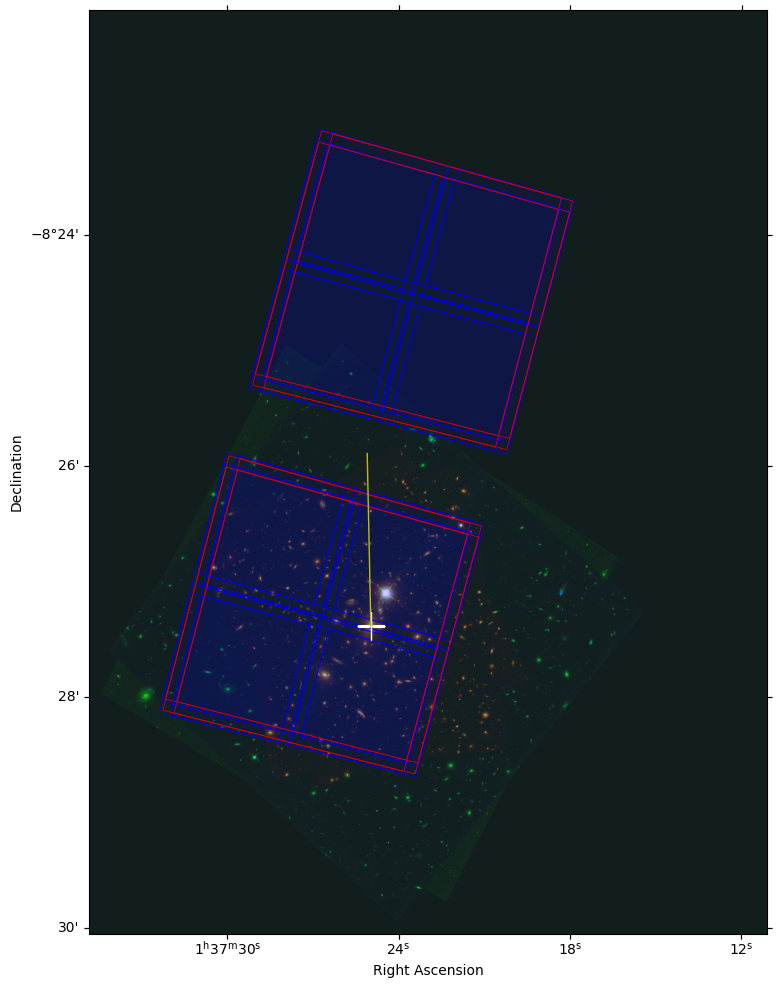

In [17]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1, projection=fits_image_wcs) # , sharex=True, sharey=True)
plt.imshow(color_image) # extent=extent)#, origin='lower')
#plt.imshow(color_image[slices], extent=extent)#, origin='lower')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')

ax = NIRCam_pointing_overlay(ax, target_coord, offset_XY, rotation_angle, dithers)
plt.show()